# SVM Models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Obtención de los datos

In [3]:
# 1. Cargar los datos
df = pd.read_csv('../../train.csv')

# 2. Crear la variable de respuesta categórica basada en los terciles del precio de venta
tercil_1 = df['SalePrice'].quantile(1/3)
tercil_2 = df['SalePrice'].quantile(2/3)

# Crear la categoría de precio
df['PriceCategory'] = pd.cut(
    df['SalePrice'], 
    bins=[0, tercil_1, tercil_2, float('inf')], 
    labels=['Económica', 'Intermedia', 'Cara']
)

# 3. Seleccionar las características para el modelo
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['PriceCategory']

## Exploración

In [4]:
X.describe()

,OverallQual,GrLivArea,GarageCars,YearBuilt,TotalBsmtSF,FullBath
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,1971.267808,1057.429452,1.565068
std,1.382997,525.480383,0.747315,30.202904,438.705324,0.550916
min,1.000000,334.000000,0.000000,1872.000000,0.000000,0.000000
25%,5.000000,1129.500000,1.000000,1954.000000,795.750000,1.000000
50%,6.000000,1464.000000,2.000000,1973.000000,991.500000,2.000000
75%,7.000000,1776.750000,2.000000,2000.000000,1298.250000,2.000000
max,10.000000,5642.000000,4.000000,2010.000000,6110.000000,3.000000


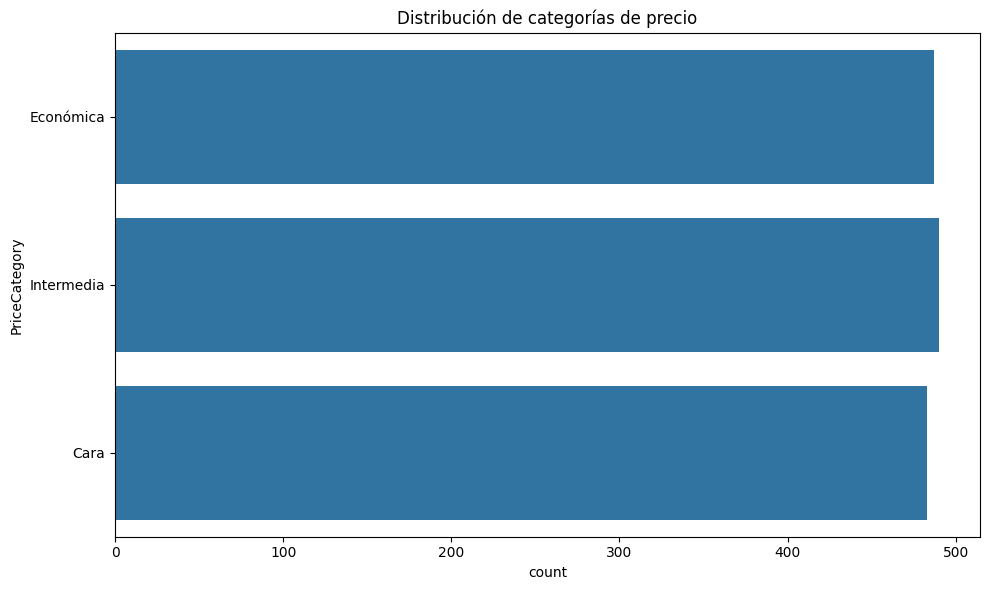

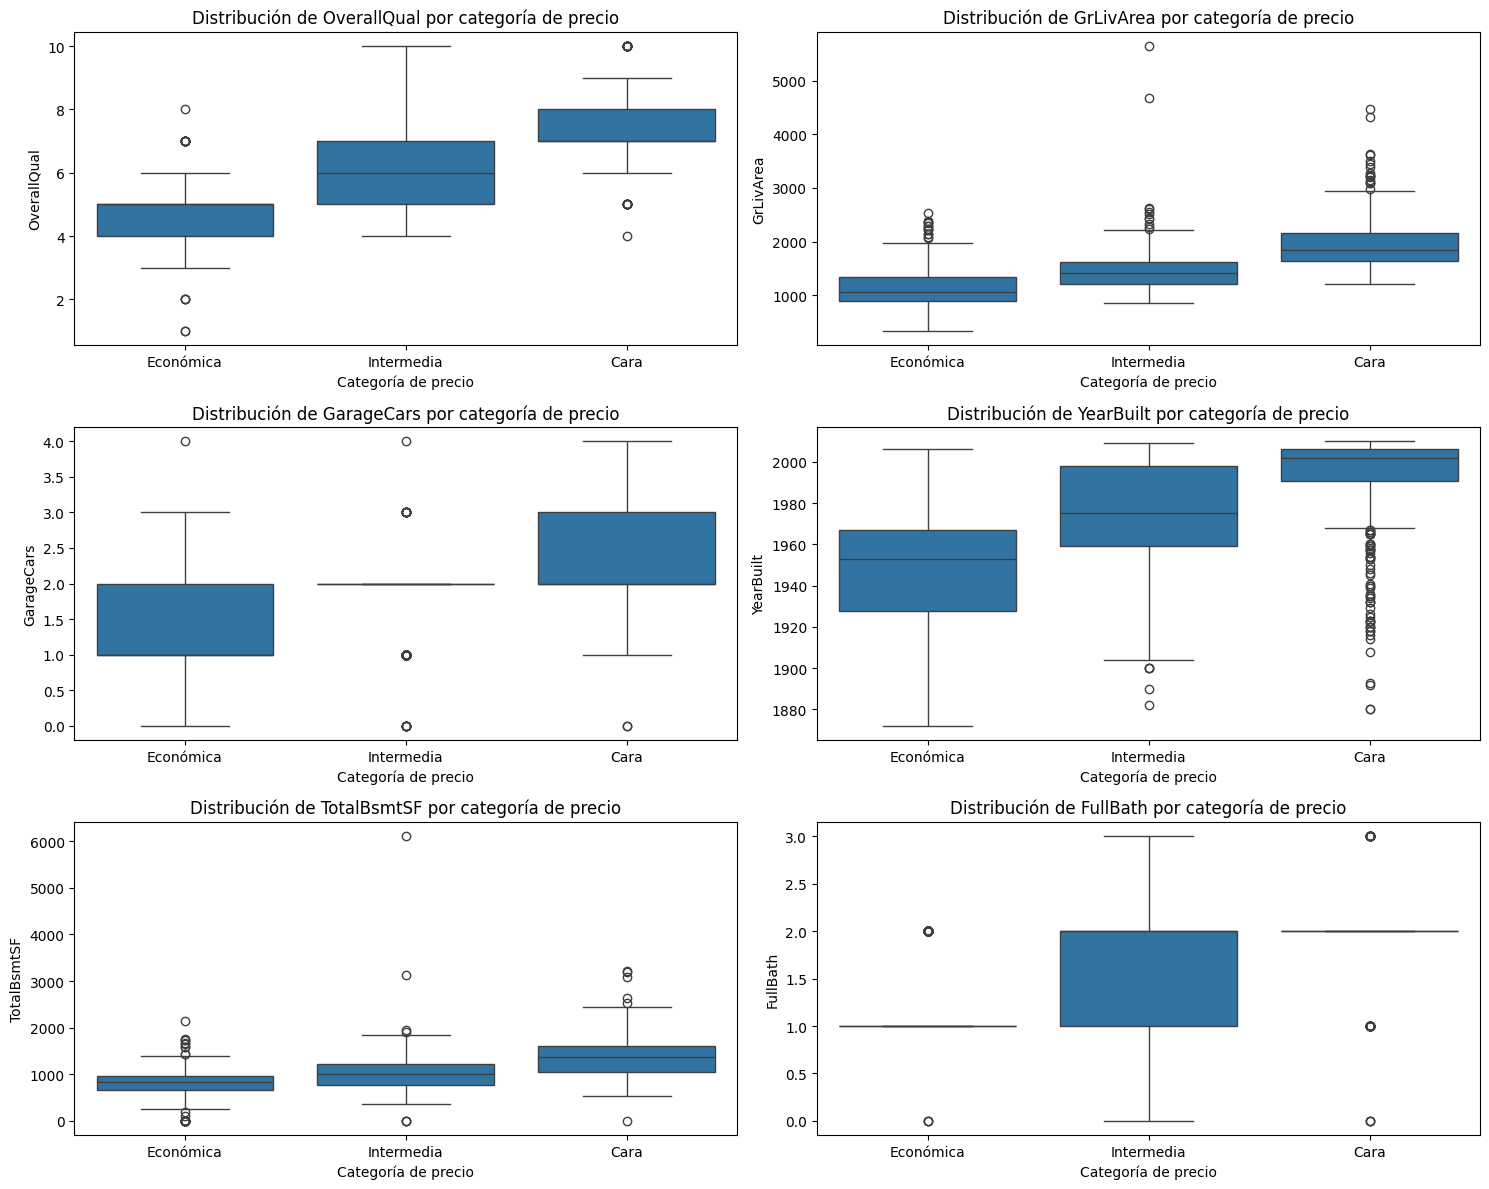

In [5]:
# 1. Distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.countplot(y=y)
plt.title('Distribución de categorías de precio')
plt.tight_layout()
plt.show()

# 2. Distribución de las variables numéricas por categoría de precio
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

numeric_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'TotalBsmtSF', 'FullBath']

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        sns.boxplot(x=df['PriceCategory'], y=df[col], ax=axes[i])
        axes[i].set_title(f'Distribución de {col} por categoría de precio')
        axes[i].set_xlabel('Categoría de precio')
        axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

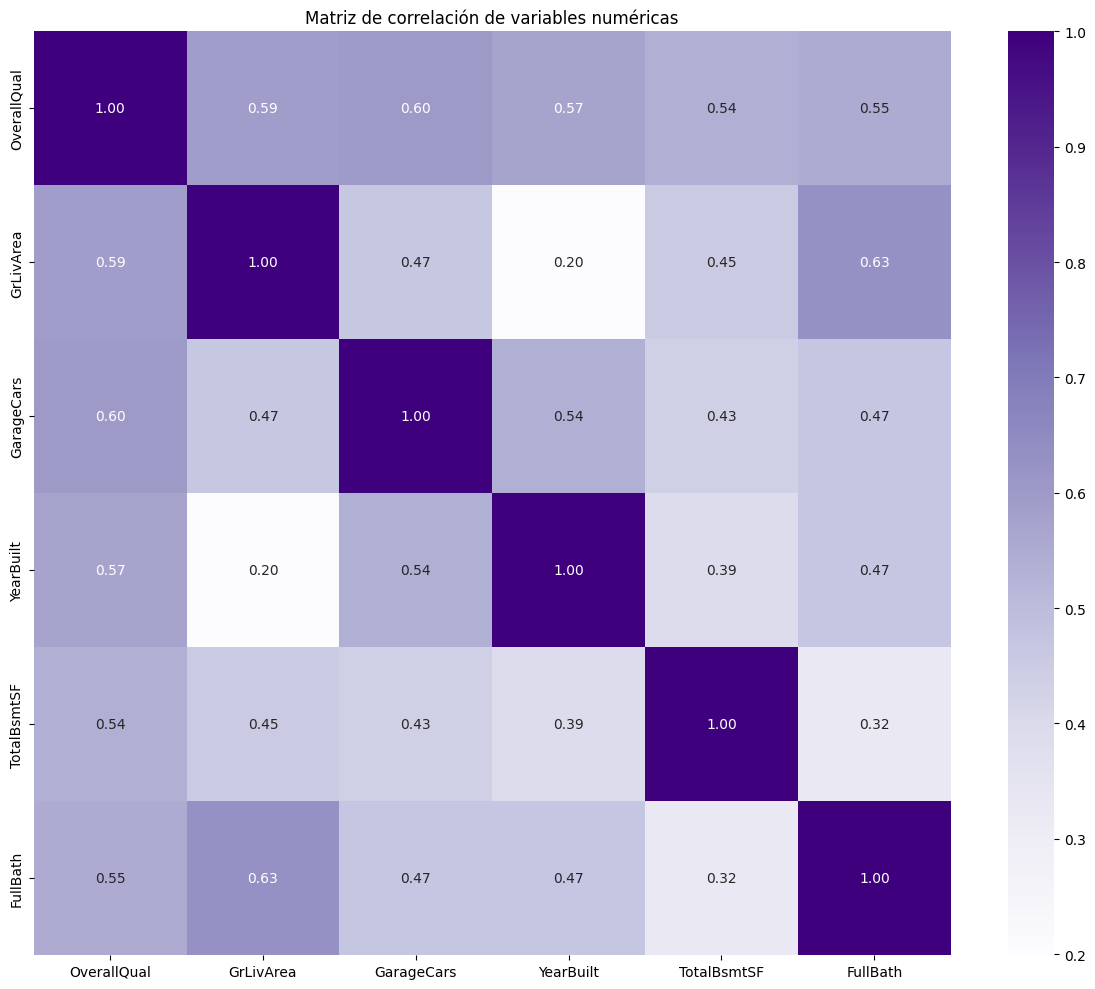

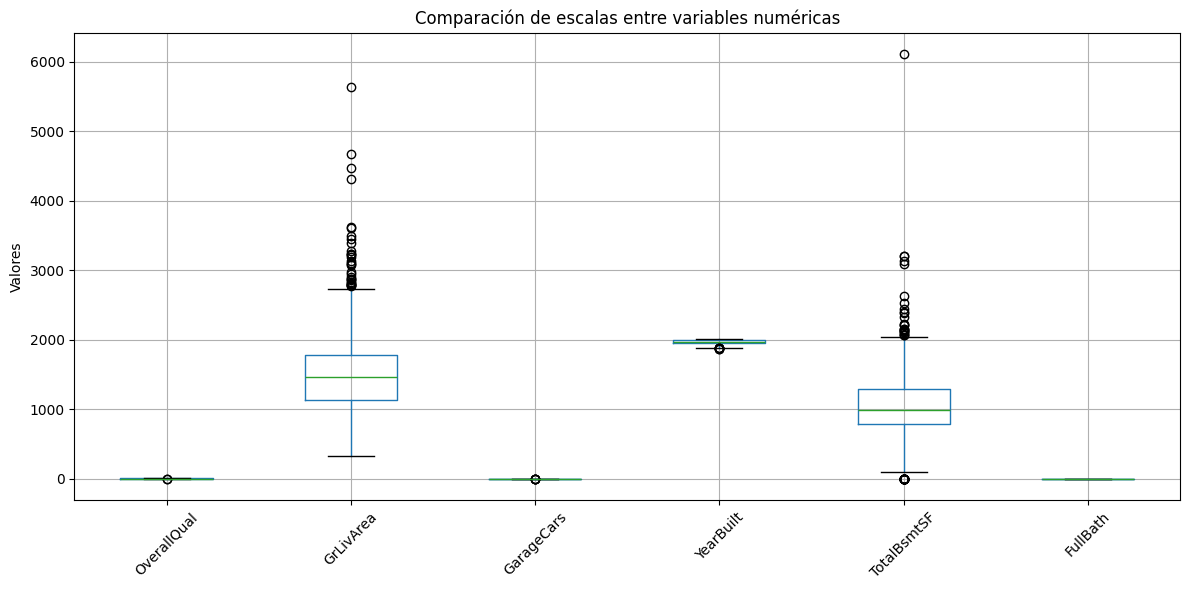

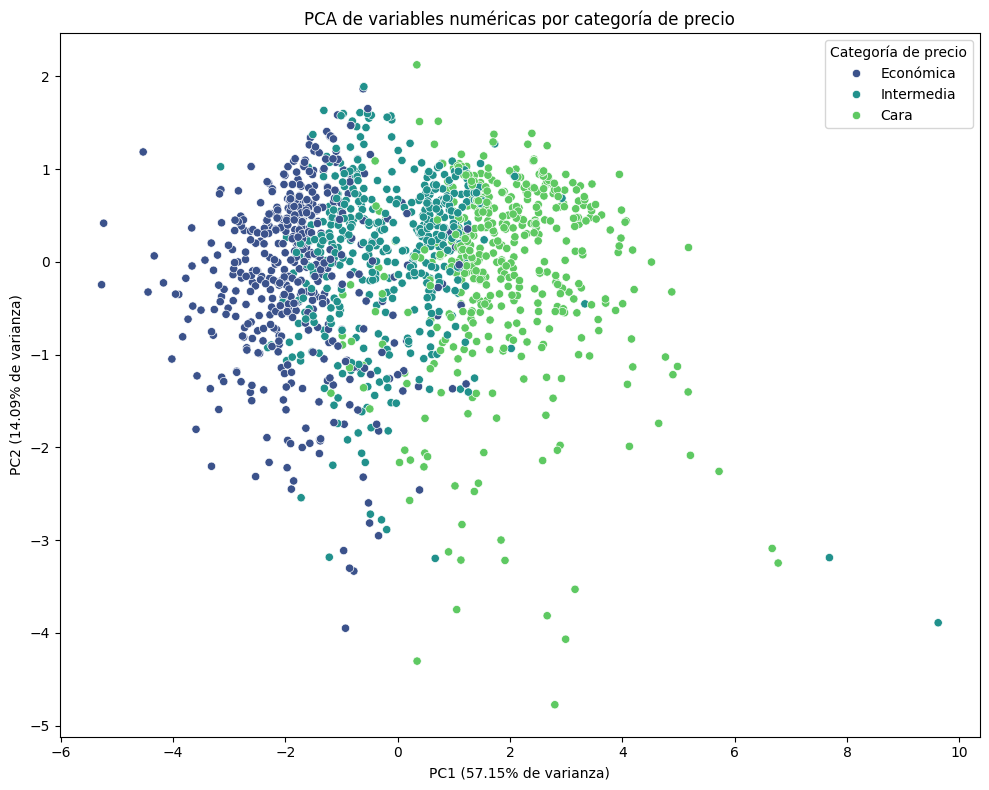

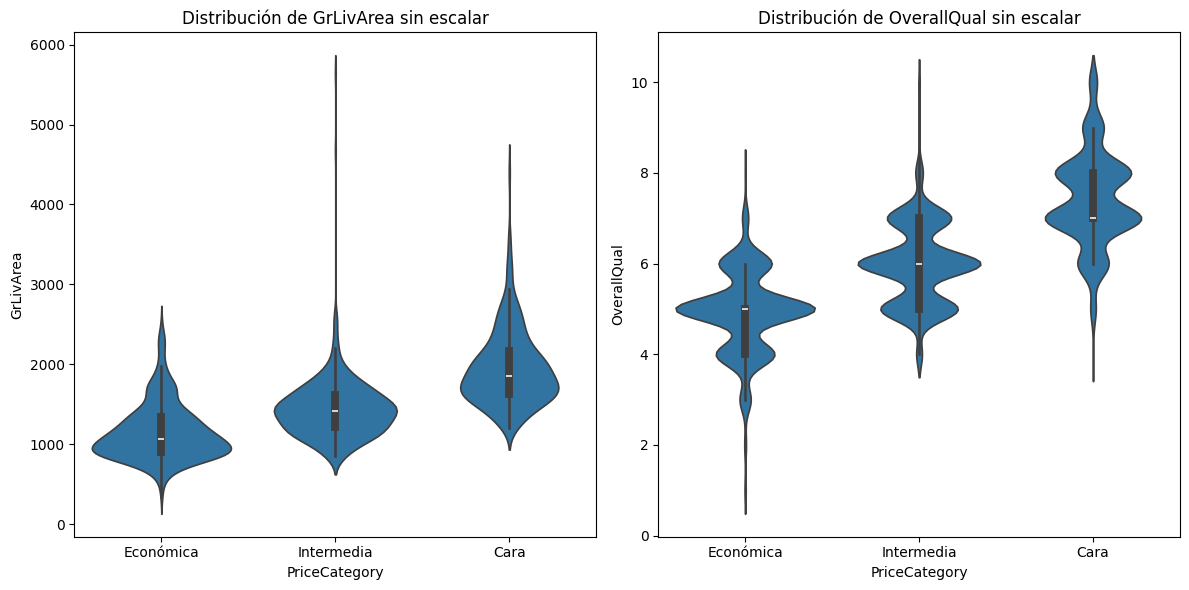

In [6]:
from sklearn.decomposition import PCA

# 3. Matriz de correlación de variables numéricas
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', fmt='.2f')
plt.title('Matriz de correlación de variables numéricas')
plt.tight_layout()
plt.show()

# 4. Análisis de la escala de las variables numéricas
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title('Comparación de escalas entre variables numéricas')
plt.ylabel('Valores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Visualización de PCA en 2D coloreado por categoría de precio
# Primero escalar los datos numéricos
from sklearn.preprocessing import StandardScaler
X_numeric = X[numeric_cols].copy()
X_numeric_scaled = StandardScaler().fit_transform(X_numeric)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric_scaled)

# Crear un DataFrame para facilitar la visualización
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['PriceCategory'] = y.values

# Visualizar
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='PriceCategory', data=pca_df, palette='viridis')
plt.title('PCA de variables numéricas por categoría de precio')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} de varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} de varianza)')
plt.legend(title='Categoría de precio')
plt.tight_layout()
plt.show()

# 7. Gráfico de violín para mostrar la necesidad de escalado
plt.figure(figsize=(12, 6))
# Seleccionar dos variables con escalas muy diferentes
var1 = 'GrLivArea'  # Área habitable (valores grandes)
var2 = 'OverallQual'  # Calidad (valores pequeños)
  
plt.subplot(1, 2, 1)
sns.violinplot(x='PriceCategory', y=var1, data=df)
plt.title(f'Distribución de {var1} sin escalar')
  
plt.subplot(1, 2, 2)
sns.violinplot(x='PriceCategory', y=var2, data=df)
plt.title(f'Distribución de {var2} sin escalar')
  
plt.tight_layout()
plt.show()

## Transformaciones

In [7]:
# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [8]:
numeric_preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Se preparan los preprocesadores
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

# Se transforman las colunas usando los preprocesadores
from sklearn.compose import ColumnTransformer

preprocesador = ColumnTransformer([
    ('one_hot_encoder',categorical_preprocessor,categorical_features),
    ('numerico', numeric_preprocessor,numeric_features)
],remainder="passthrough")

## Modelos SVM clasificación

In [9]:
# kernel lineal, C por defecto
modelo_svc_lineal = make_pipeline(preprocesador, SVC(kernel="linear"))

# Esto nos permite ver dentro del modelo
from sklearn import set_config
set_config(display='diagram')
modelo_svc_lineal

modelo_svc_lineal.fit(X_train, y_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32)
    }
modelGS_svc_lineal = GridSearchCV(modelo_svc_lineal, param_grid=param_grid,
                                 n_jobs=2, cv=10)
modelGS_svc_lineal.fit(X_train, y_train)
accuracy = modelGS_svc_lineal.score(X_test,y_test)
print("Accuracy: ",accuracy)
modelGS_svc_lineal.best_params_

Accuracy:  0.7990867579908676


{'svc__C': 0.1}

In [10]:
# kernel polinomial
modelo_svc_poly = make_pipeline(preprocesador, SVC(kernel="poly"))

modelo_svc_poly.fit(X_train, y_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32),
    'svc__degree':(2,3,5,7)
    }
modelGS_svc_poly = GridSearchCV(modelo_svc_poly, param_grid=param_grid,
                                 n_jobs=2, cv=10)
modelGS_svc_poly.fit(X_train, y_train)
accuracy = modelGS_svc_poly.score(X_test,y_test)
print("Accuracy: ",accuracy)
modelGS_svc_poly.best_params_

Accuracy:  0.773972602739726


{'svc__C': 1, 'svc__degree': 2}

In [11]:
# kernel gaussiano
modelo_svc_rbf = make_pipeline(preprocesador, SVC(kernel="rbf"))

modelo_svc_rbf.fit(X_train, y_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32),
    'svc__gamma':(0.0000000002,0.00002,0.01,0.1,20,200 )
    }
modelGS_svc_rbf = GridSearchCV(modelo_svc_rbf, param_grid=param_grid,
                                 n_jobs=2, cv=10)
modelGS_svc_rbf.fit(X_train, y_train)
accuracy = modelGS_svc_rbf.score(X_test, y_test)
print("Accuracy: ",accuracy)
modelGS_svc_rbf.best_params_

Accuracy:  0.7922374429223744


{'svc__C': 32, 'svc__gamma': 0.01}

#### Predicción

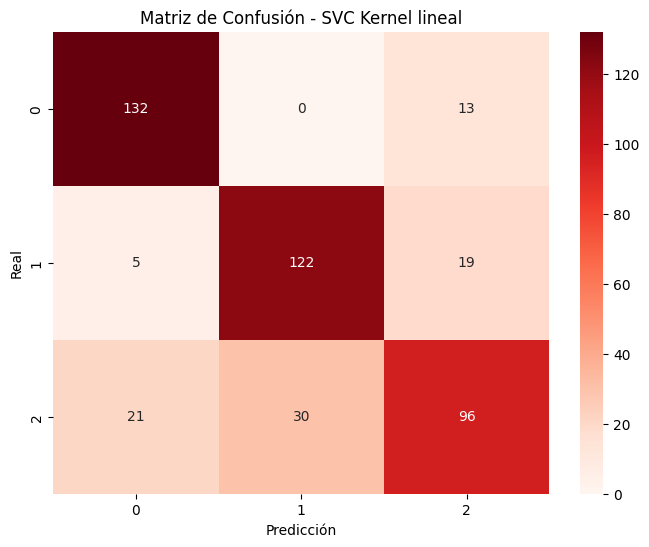

In [12]:
y_pred_lineal = modelGS_svc_lineal.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lineal)
# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC Kernel lineal")
plt.show()

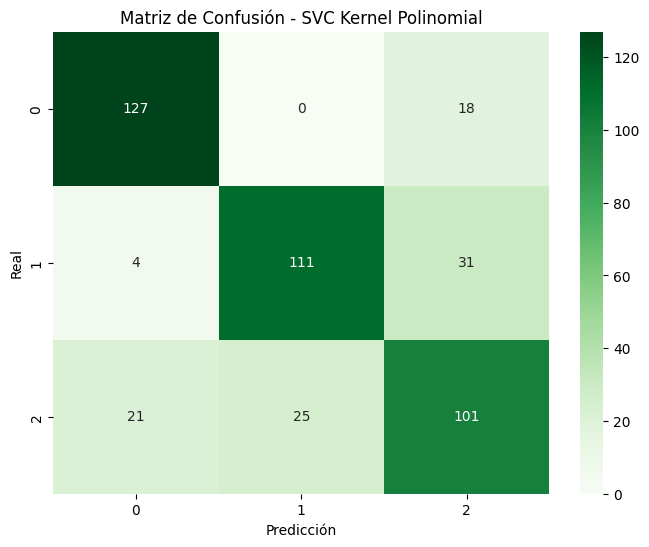

In [13]:
y_pred_poly = modelGS_svc_poly.predict(X_test)
cm = confusion_matrix(y_test, y_pred_poly)
# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC Kernel Polinomial")
plt.show()

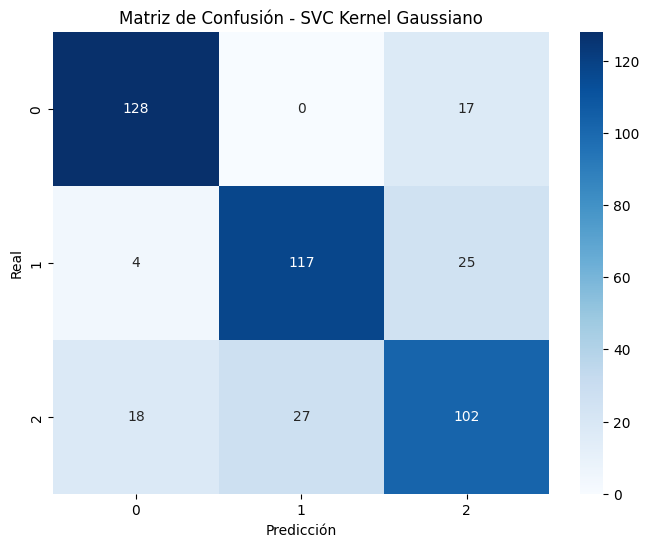

In [14]:
y_pred_rbf = modelGS_svc_rbf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rbf)
# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVC Kernel Gaussiano")
plt.show()

## 7. Análisis de sobreajuste/desajuste

SVM Lineal:
  Precisión train: 0.8630
  Precisión test: 0.7991
  Diferencia: 0.0639
  DIAGNÓSTICO: Ajuste adecuado
SVM Polinomial:
  Precisión train: 0.8718
  Precisión test: 0.7740
  Diferencia: 0.0978
  DIAGNÓSTICO: Ajuste adecuado
SVM RBF:
  Precisión train: 0.8836
  Precisión test: 0.7922
  Diferencia: 0.0913
  DIAGNÓSTICO: Ajuste adecuado
Analizando curva de aprendizaje para SVM Lineal


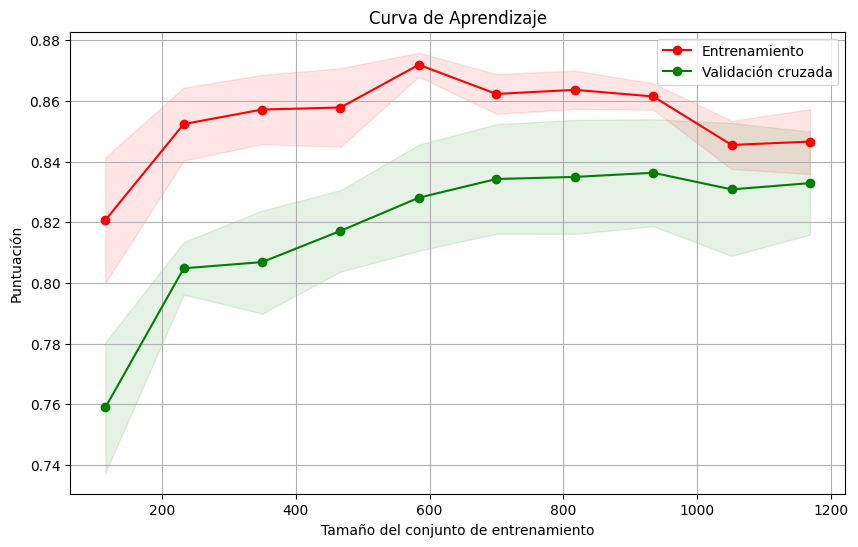

In [15]:
# Evaluar sobreajuste en los modelos SVM
models = {
    'SVM Lineal': modelGS_svc_lineal,
    'SVM Polinomial': modelGS_svc_poly,
    'SVM RBF': modelGS_svc_rbf
}

# Comparar rendimiento en train vs test
for name, model in models.items():
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    diff = train_accuracy - test_accuracy
    
    print(f"{name}:")
    print(f"  Precisión train: {train_accuracy:.4f}")
    print(f"  Precisión test: {test_accuracy:.4f}")
    print(f"  Diferencia: {diff:.4f}")
    
    if diff > 0.1:
        print("  DIAGNÓSTICO: Posible sobreajuste")
    elif test_accuracy < 0.7:
        print("  DIAGNÓSTICO: Posible subajuste")
    else:
        print("  DIAGNÓSTICO: Ajuste adecuado")

# Visualizar curva de aprendizaje para el mejor modelo
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Curva de Aprendizaje")
    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Puntuación")
    plt.grid()
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación cruzada")
    plt.legend(loc="best")
    plt.show()

# Encontrar el mejor modelo
best_model_name = max(models.items(), key=lambda x: x[1].score(X_test, y_test))[0]
best_model = models[best_model_name]
print(f"Analizando curva de aprendizaje para {best_model_name}")
plot_learning_curve(best_model, X, y)

## 8. Comparación entre modelos SVM



--- SVM Lineal ---
Tiempo de procesamiento: 0.01608 segundos
Precisión: 0.7991


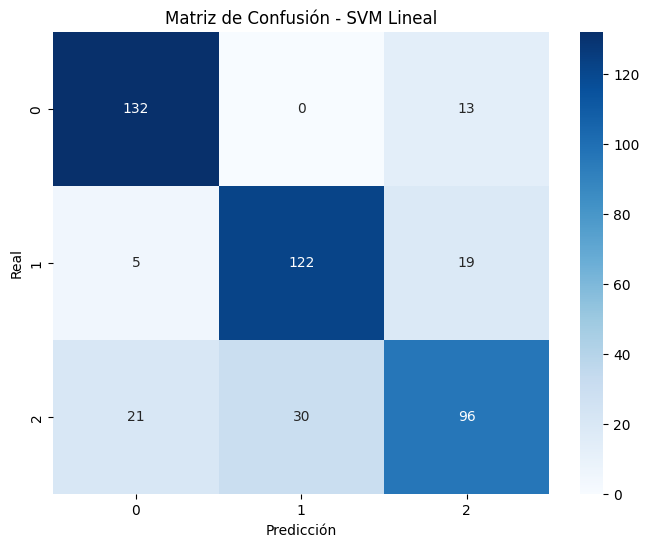


Reporte de clasificación:
              precision    recall  f1-score   support

        Cara       0.84      0.91      0.87       145
   Económica       0.80      0.84      0.82       146
  Intermedia       0.75      0.65      0.70       147

    accuracy                           0.80       438
   macro avg       0.80      0.80      0.80       438
weighted avg       0.80      0.80      0.80       438

Total de errores: 88
Distribución de errores:
Real
Intermedia    51
Económica     24
Cara          13
Name: count, dtype: int64

Tipos de errores:
Real        Predicción
Económica   Cara           5
            Económica      0
            Intermedia    19
Intermedia  Cara          21
            Económica     30
            Intermedia     0
Cara        Cara           0
            Económica      0
            Intermedia    13
dtype: int64

--- SVM Polinomial ---
Tiempo de procesamiento: 0.01407 segundos
Precisión: 0.7740


C:\Users\villa\AppData\Local\Temp\ipykernel_10248\3945814038.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(error_df.groupby(['Real', 'Predicción']).size())


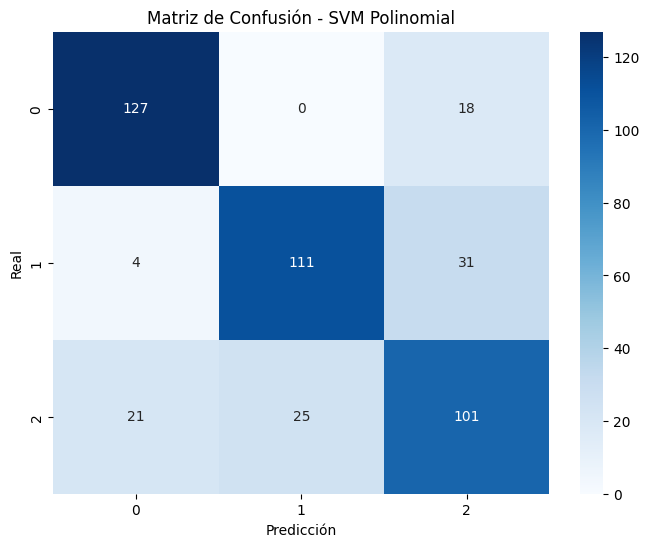


Reporte de clasificación:
              precision    recall  f1-score   support

        Cara       0.84      0.88      0.86       145
   Económica       0.82      0.76      0.79       146
  Intermedia       0.67      0.69      0.68       147

    accuracy                           0.77       438
   macro avg       0.78      0.77      0.77       438
weighted avg       0.77      0.77      0.77       438

Total de errores: 99
Distribución de errores:
Real
Intermedia    46
Económica     35
Cara          18
Name: count, dtype: int64

Tipos de errores:
Real        Predicción
Económica   Cara           4
            Económica      0
            Intermedia    31
Intermedia  Cara          21
            Económica     25
            Intermedia     0
Cara        Cara           0
            Económica      0
            Intermedia    18
dtype: int64

--- SVM RBF ---
Tiempo de procesamiento: 0.01145 segundos
Precisión: 0.7922


C:\Users\villa\AppData\Local\Temp\ipykernel_10248\3945814038.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(error_df.groupby(['Real', 'Predicción']).size())


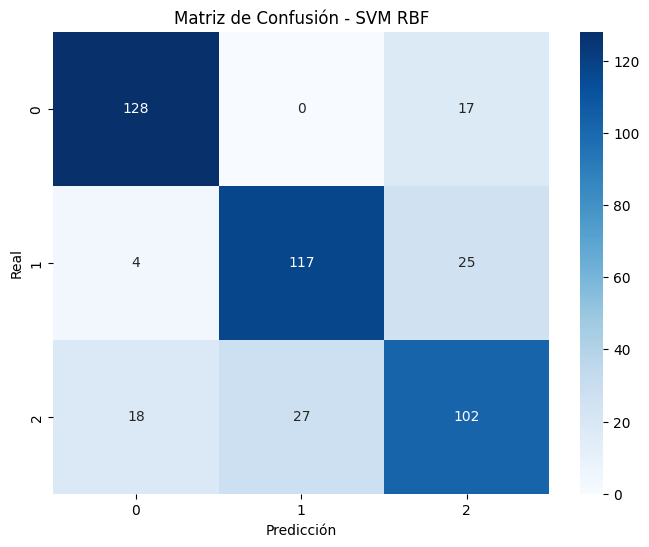


Reporte de clasificación:
              precision    recall  f1-score   support

        Cara       0.85      0.88      0.87       145
   Económica       0.81      0.80      0.81       146
  Intermedia       0.71      0.69      0.70       147

    accuracy                           0.79       438
   macro avg       0.79      0.79      0.79       438
weighted avg       0.79      0.79      0.79       438

Total de errores: 91
Distribución de errores:
Real
Intermedia    45
Económica     29
Cara          17
Name: count, dtype: int64

Tipos de errores:
Real        Predicción
Económica   Cara           4
            Económica      0
            Intermedia    25
Intermedia  Cara          18
            Económica     27
            Intermedia     0
Cara        Cara           0
            Económica      0
            Intermedia    17
dtype: int64


C:\Users\villa\AppData\Local\Temp\ipykernel_10248\3945814038.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(error_df.groupby(['Real', 'Predicción']).size())
C:\Users\villa\AppData\Local\Temp\ipykernel_10248\3945814038.py:63: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:green'` for the same effect.

  sns.barplot(x='Modelo', y='Precisión', hue='Categoría', data=metrics_df, color="green")
C:\Users\villa\AppData\Local\Temp\ipykernel_10248\3945814038.py:68: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:green'` for the same effect.

  sns.barplot(x='Modelo', y='Recall', hue='Categoría', data=metrics_df, color="green")
C:\Users\villa\AppData

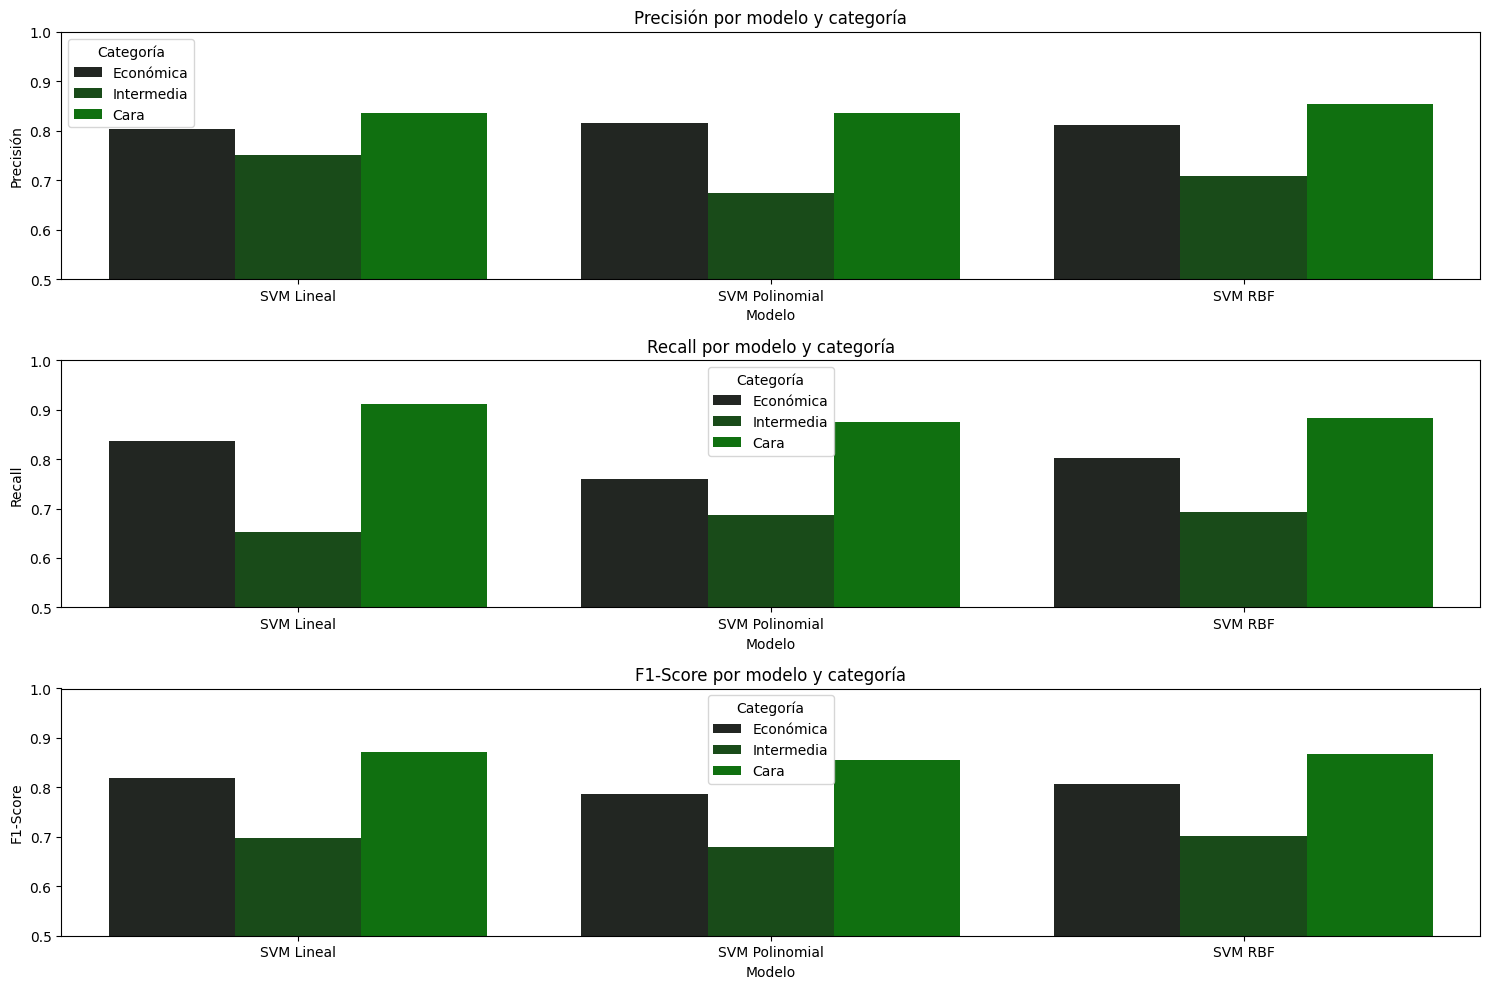

In [ ]:
# Métricas detalladas para cada modelo
import time


for name, model in models.items():
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    process_time = end_time - start_time
    
    print(f"\n--- {name} ---")
    print(f"Tiempo de procesamiento: {process_time:.5f} segundos")
    print(f"Precisión: {accuracy_score(y_test, y_pred):.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()
    
    # Reporte detallado
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Análisis de errores
    errors = np.where(y_pred != y_test)[0]
    print(f"Total de errores: {len(errors)}")
    if len(errors) > 0:
        print("Distribución de errores:")
        error_df = pd.DataFrame({
            'Real': y_test.iloc[errors],
            'Predicción': y_pred[errors]
        })
        print(error_df['Real'].value_counts())
        print("\nTipos de errores:")
        print(error_df.groupby(['Real', 'Predicción']).size())

# Comparación visual de métricas
metrics_data = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    for category in ['Económica', 'Intermedia', 'Cara']:
        metrics_data.append({
            'Modelo': name,
            'Categoría': category,
            'Precisión': report[category]['precision'],
            'Recall': report[category]['recall'],
            'F1-Score': report[category]['f1-score']
        })

metrics_df = pd.DataFrame(metrics_data)

# Gráficos de comparación
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sns.barplot(x='Modelo', y='Precisión', hue='Categoría', data=metrics_df)
plt.title('Precisión por modelo y categoría')
plt.ylim(0.5, 1.0)

plt.subplot(3, 1, 2)
sns.barplot(x='Modelo', y='Recall', hue='Categoría', data=metrics_df)
plt.title('Recall por modelo y categoría')
plt.ylim(0.5, 1.0)

plt.subplot(3, 1, 3)
sns.barplot(x='Modelo', y='F1-Score', hue='Categoría', data=metrics_df)
plt.title('F1-Score por modelo y categoría')
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

## 9. Comparación con otros algoritmos


In [ ]:
# Comparar SVM con otros algoritmos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time

models_to_compare = {
    'SVM (Mejor)': best_model,
    'Árbol de Decisión': make_pipeline(preprocesador, DecisionTreeClassifier(random_state=42)),
    'Random Forest': make_pipeline(preprocesador, RandomForestClassifier(random_state=42)),
    'Naive Bayes': make_pipeline(preprocesador, GaussianNB()),
    'KNN': make_pipeline(preprocesador, KNeighborsClassifier()),
    'Regresión Logística': make_pipeline(preprocesador, LogisticRegression(max_iter=1000, random_state=42))
}

# Entrenar y evaluar cada modelo
results = []

for name, model in models_to_compare.items():
    if name != 'SVM (Mejor)':
        print(f"Entrenando {name}...")
        start_train = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_train
    else:
        train_time = None
    
    # Medir tiempo de predicción
    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'Modelo': name,
        'Precisión': accuracy,
        'Tiempo de entrenamiento': train_time,
        'Tiempo de predicción': pred_time
    })

# Crear dataframe con resultados
results_df = pd.DataFrame(results)
print(results_df)

# Visualizar comparativa
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Modelo', y='Precisión', data=results_df)
plt.title('Comparación de Precisión entre Algoritmos')
plt.ylim(0.6, 1.0)
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.barplot(x='Modelo', y='Tiempo de predicción', data=results_df)
plt.title('Comparación de Tiempo de Predicción')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 10. Modelo de regresión para precio directo


Entrenando SVR Lineal...
RMSE: 82256.58
R²: 0.0304


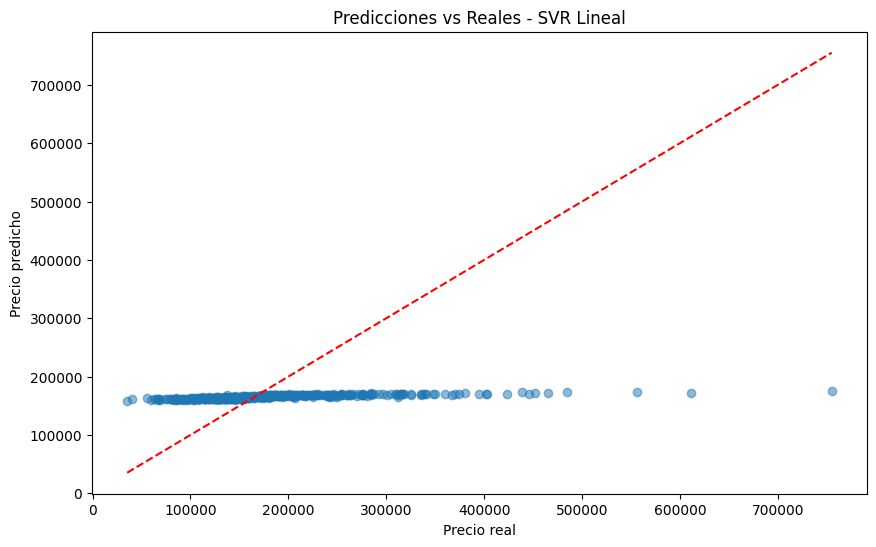

Entrenando SVR Polinomial...
RMSE: 84630.85
R²: -0.0264


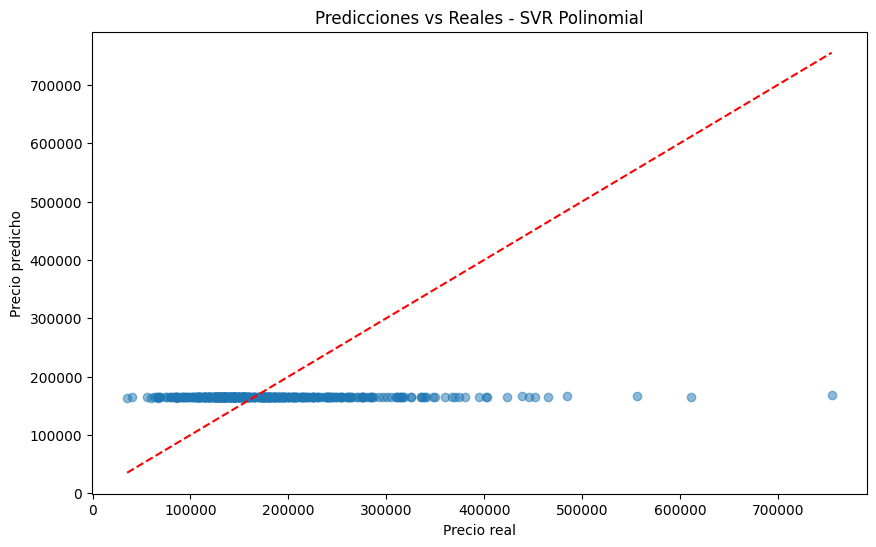

Entrenando SVR RBF...
RMSE: 84800.81
R²: -0.0305


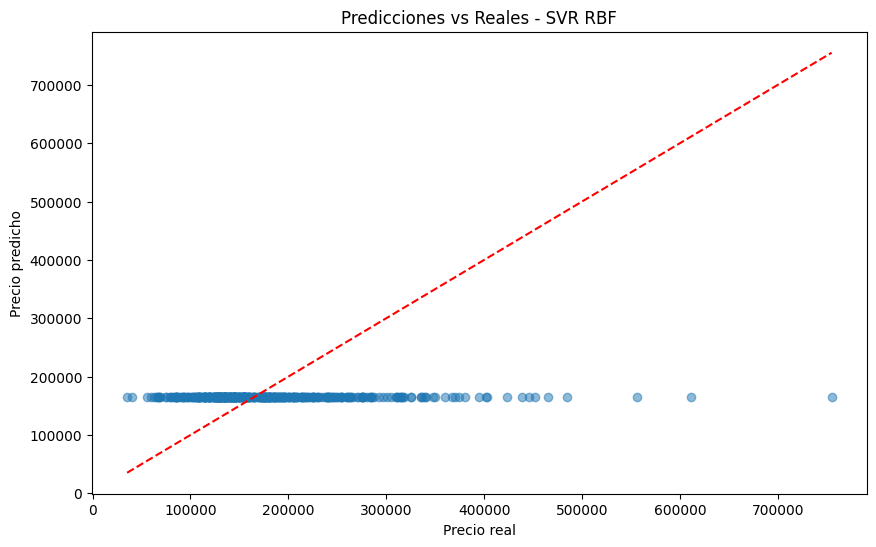

Optimizando modelo SVR con kernel RBF...
Mejores parámetros: {'svr__C': 100, 'svr__epsilon': 0.2, 'svr__gamma': 0.1}
RMSE con modelo optimizado: 78588.14
R² con modelo optimizado: 0.1149


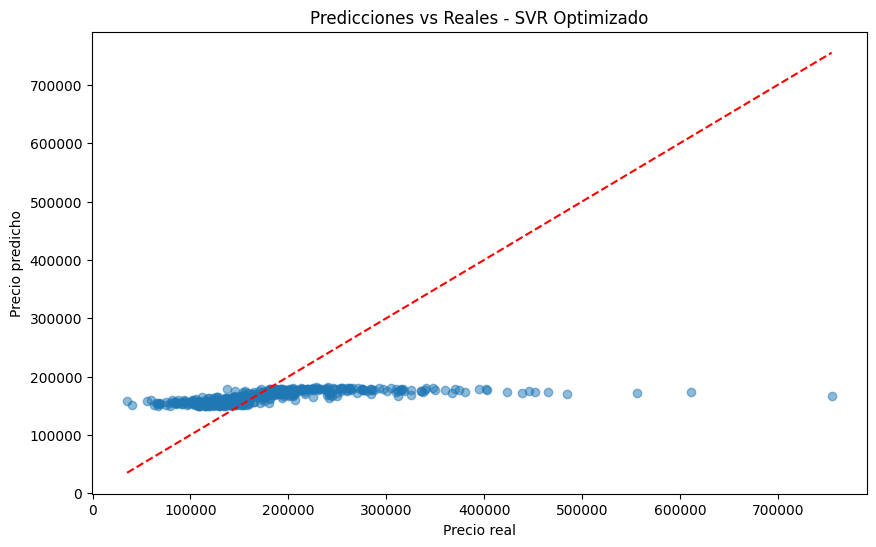

In [18]:
# Crear modelo de regresión con SVM
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Preparar variable para regresión
y_reg = df['SalePrice']

# División de datos para regresión
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

# Crear modelos con diferentes kernels
svr_models = {
    'SVR Lineal': make_pipeline(preprocesador, SVR(kernel='linear')),
    'SVR Polinomial': make_pipeline(preprocesador, SVR(kernel='poly', degree=3)),
    'SVR RBF': make_pipeline(preprocesador, SVR(kernel='rbf'))
}

# Evaluar modelos base
for name, model in svr_models.items():
    print(f"Entrenando {name}...")
    model.fit(X_train_reg, y_train_reg)
    
    y_pred = model.predict(X_test_reg)
    
    # Métricas
    rmse = math.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Visualizar predicciones
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_reg, y_pred, alpha=0.5)
    plt.plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 
             'r--')
    plt.xlabel('Precio real')
    plt.ylabel('Precio predicho')
    plt.title(f'Predicciones vs Reales - {name}')
    plt.show()

# Ajuste de hiperparámetros para el mejor modelo (ejemplo con RBF)
print("Optimizando modelo SVR con kernel RBF...")
param_grid_svr = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svr__epsilon': [0.01, 0.1, 0.2]
}

grid_svr = GridSearchCV(
    svr_models['SVR RBF'], 
    param_grid_svr, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_svr.fit(X_train_reg, y_train_reg)
print("Mejores parámetros:", grid_svr.best_params_)

# Evaluar modelo optimizado
y_pred_best = grid_svr.predict(X_test_reg)
rmse_best = math.sqrt(mean_squared_error(y_test_reg, y_pred_best))
r2_best = r2_score(y_test_reg, y_pred_best)

print(f"RMSE con modelo optimizado: {rmse_best:.2f}")
print(f"R² con modelo optimizado: {r2_best:.4f}")

# Visualizar resultados del modelo optimizado
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_best, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Predicciones vs Reales - SVR Optimizado')
plt.show()

## 11. Comparación con otros modelos de regresión

Entrenando Regresión Lineal...
Entrenando Árbol de Regresión...
Entrenando Random Forest...
Entrenando KNN Regressor...
               Modelo          RMSE        R²           MAE  Tiempo predicción
0    SVR (Optimizado)  78588.144738  0.114931  48507.977871           0.134362
1    Regresión Lineal  31492.138902  0.857876  20532.772702           0.005002
2  Árbol de Regresión  43285.335248  0.731500  27933.949772           0.003001
3       Random Forest  26008.332463  0.903063  17464.776424           0.016083
4       KNN Regressor  54578.586579  0.573118  34248.324201           0.029104


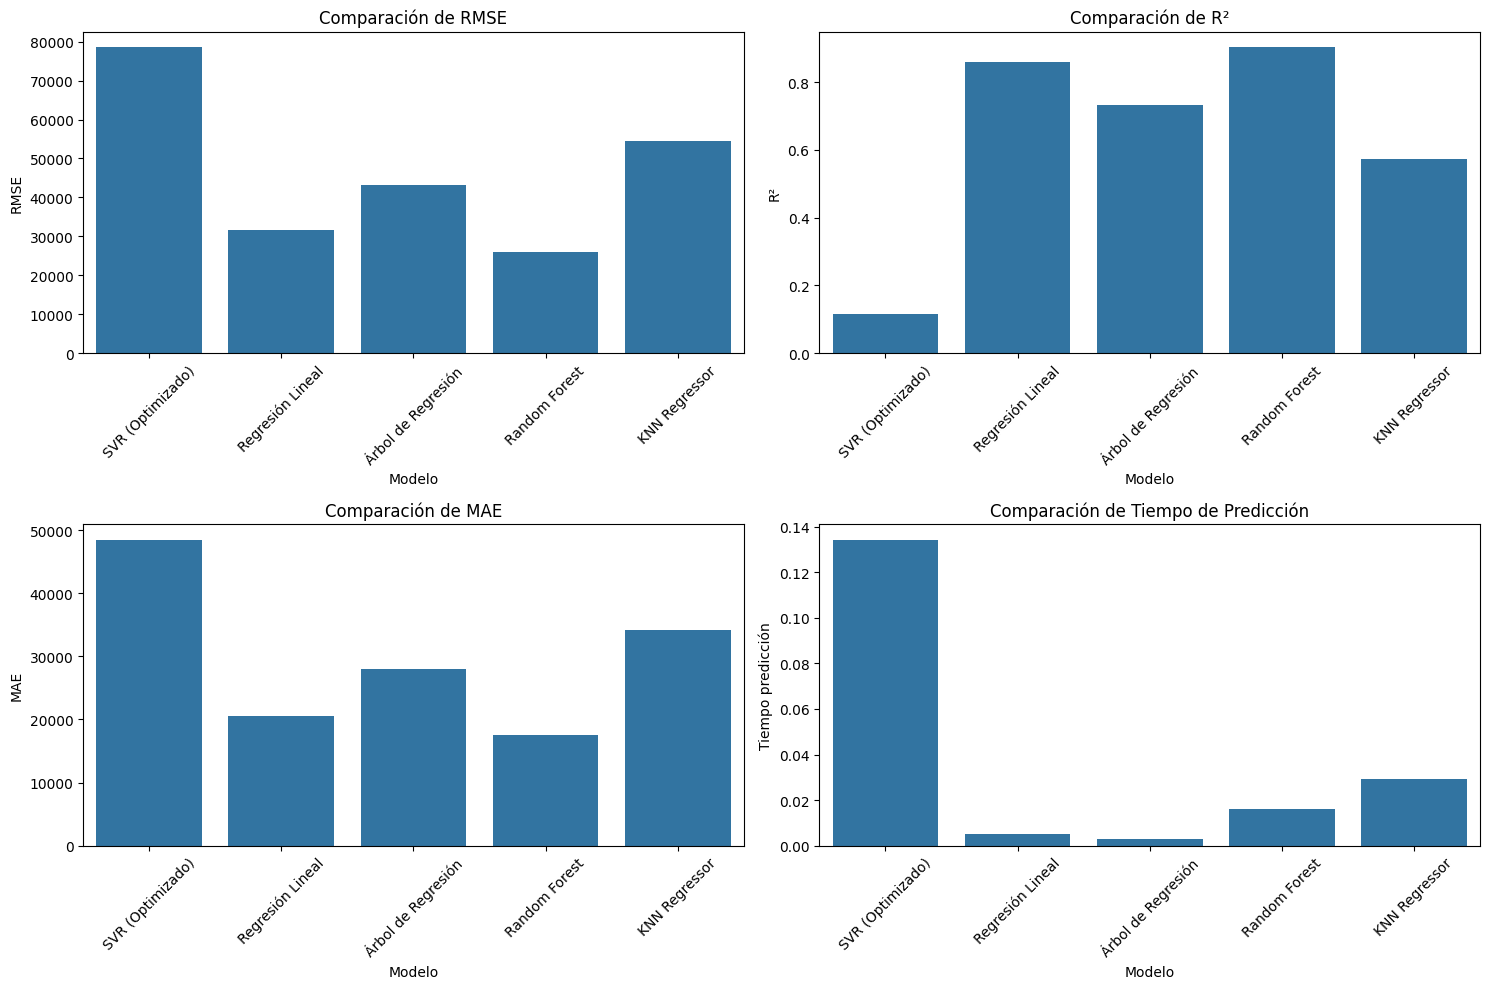

In [19]:
# Comparar con modelos de regresión anteriores
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

reg_models = {
    'SVR (Optimizado)': grid_svr,
    'Regresión Lineal': make_pipeline(preprocesador, LinearRegression()),
    'Árbol de Regresión': make_pipeline(preprocesador, DecisionTreeRegressor(random_state=42)),
    'Random Forest': make_pipeline(preprocesador, RandomForestRegressor(random_state=42)),
    'KNN Regressor': make_pipeline(preprocesador, KNeighborsClassifier(n_neighbors=5))
}

# Entrenar y evaluar
reg_results = []

for name, model in reg_models.items():
    if name != 'SVR (Optimizado)':
        print(f"Entrenando {name}...")
        model.fit(X_train_reg, y_train_reg)
    
    start_time = time.time()
    y_pred = model.predict(X_test_reg)
    pred_time = time.time() - start_time
    
    # Métricas
    rmse = math.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    mae = mean_absolute_error(y_test_reg, y_pred)
    
    reg_results.append({
        'Modelo': name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'Tiempo predicción': pred_time
    })

# Crear dataframe y visualizar
reg_df = pd.DataFrame(reg_results)
print(reg_df)

# Visualización comparativa
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='Modelo', y='RMSE', data=reg_df)
plt.title('Comparación de RMSE')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.barplot(x='Modelo', y='R²', data=reg_df)
plt.title('Comparación de R²')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='MAE', data=reg_df)
plt.title('Comparación de MAE')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='Tiempo predicción', data=reg_df)
plt.title('Comparación de Tiempo de Predicción')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()